# Analysis

## Setup

In [1]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean
import numpy as np
from copy import deepcopy
from datetime import datetime
from time import time
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import pandas as pd

### 2. Define the 'ecrest' class using functions from CREST.py

An instance of this object will be able to:
- open an neuroglancer viewer for proofrieading (see "Proofread using CREST")
    - add-remove segments (using graph feature for efficiency)
    - format itself and save itself as a CREST-style .json
- convert from neuroglancer json (see "Convert From Neuroglancer to eCREST")
    - format itself and save itself as a CREST-style .json
    
Run the following code cell to define the crest_json class

In [2]:
class ecrest:
    
    def __init__(self,settings_dict, segment_id = None, segment_list = None, filepath = None, launch_viewer=False):
        
        '''
        At some point, store these initialization values (ie addresses, keys lists) as a 'params' file that can be provided to the init function instead of hard-coding
        
        main_base_id : base segment ID from neuroglancer list
        
        db_path : filepath to agglomeration database sql file locally on computer
        
        '''
        #####
        
        '''
        set up local stuff
        '''
        
        self.import_from_settings_dict(settings_dict)
        self.launch_viewer = launch_viewer
        
        # Create the connection to the database (right now just for 'Cell Reconstruction')
        self.connect_db(self.db_paths)
        
        # Set up addresses
        # addresses are stored in the agglomo SQL file        
        required_addresses = ['agglo_address', 'base_address', 'em_address', 'cloud_storage_address']
        [self.agglo_seg, self.base_seg, self.em, self.cloud_storage_address]  = self.get_addresses(required_addresses)
       
        self.cell_pos = 0
        self.start_time = time()
        self.link_opened = False

        self.get_vx_sizes()
        self.added_keybindings = set()
        
        if segment_id!=None: 
            # initialize from segment ID
            self.load_from_segment_id(segment_id,segment_list)
            
        if filepath!=None:
            # initialize from file (crest .json state)
            self.load_from_file(filepath)
        #####
        
        '''
        Set up neuroglancer viewer
        '''
        
        if launch_viewer==True:
            self.viewer = neuroglancer.Viewer()
            self.viewer.set_state({})

            # Add keybindings:
            pr_keybindings = {
                'change-structure': lambda s: self.change_cell_structure(),
                'change-anchor-seg': self.change_anchor_seg,
                'add-or-remove-seg': self.add_or_remove_seg,
                'mark-branch-in-colour': self.mark_branch_in_colour,
                'change-point' : lambda s: self.change_point()
                # 'grow-graph': lambda s: self.grow_graph(), ### WHY IS GROW GRAPH DISABLED? SEEMS USEFUL FOR LABELING CELL STRUCTURES AFTER ADDING SEGMENTS?
                # 'increase-threshold': lambda s: self.increase_threshold(),
                # 'decrease-threshold': lambda s: self.decrease_threshold(),
                # 'start-branch-focus': self.branch_focus,
                # 'accept-new-segs': lambda s: self.accept_new_segs(),        
            }

            self.add_keybindings_no_duplicates(pr_keybindings)            

            with self.viewer.config_state.txn() as s:
                s.input_event_bindings.viewer['keyc'] = 'change-structure'
                s.input_event_bindings.data_view['dblclick0'] = 'add-or-remove-seg'
                s.input_event_bindings.data_view['alt+mousedown0'] = 'mark-branch-in-colour'
                s.input_event_bindings.data_view['shift+mousedown2'] = 'change-anchor-seg'
                s.input_event_bindings.data_view['keyp'] = 'change-point'
                # s.input_event_bindings.viewer['keyg'] = 'grow-graph'
                # s.input_event_bindings.viewer['keyk'] = 'increase-threshold'
                # s.input_event_bindings.viewer['keyj'] = 'decrease-threshold'
                # s.input_event_bindings.viewer['keya'] = 'accept-new-segs'
                # s.input_event_bindings.data_view['shift+mousedown0'] = 'start-branch-focus'

            with self.viewer.config_state.txn() as s:
                s.show_layer_panel = True ###
                
            # setup point annoations
            self.set_endpoint_annotation_layers()
            self.set_base_seg_merger_layer()
            self.point_pos = -1
            self.change_point()

            self.set_seg_colours()
            self.cell_structure_pos = -1
            self.change_cell_structure()

            loc = self.get_locations_from_base_segs([self.cell_data['metadata']['main_seg']['base']])[self.cell_data['metadata']['main_seg']['base']]
            self.change_view(loc, css=0.22398, ps=389.338)
            self.reset_seg_pr_layers()

            b = self.cell_data['base_segments']
            second_part = ', '.join([f'{x}: {len(b[x])}' for x in b.keys()])
            print(f'updating viewer status message: Current Base Segment Counts: {second_part}')
            with self.viewer.config_state.txn() as s:
                s.status_messages['current_seg_count'] = f'Current Base Segment Counts: {second_part}'

            self.open_ng_link()
            # self.assert_segs_in_sync()

    def open_ng_link(self):

        if not self.link_opened:
            wb_open(str(self.viewer))
            self.link_opened = True

    def import_from_settings_dict(self,settings_dict):
        # self.settings_dict = settings_dict
        self.db_paths = Path(settings_dict['db_path'])
        self.point_types = settings_dict['annotation_points']
        self.cell_structures = settings_dict['cell_structures']
        self.max_num_base_added = settings_dict['max_num_base_added']
        self.save_dir = Path(settings_dict['save_dir'])

    def add_keybindings_no_duplicates(self, dict):

        for k in dict:

            if k not in self.added_keybindings:

                self.viewer.actions.add(k, dict[k])
                self.added_keybindings.add(k)           
                
    def load_from_segment_id(self,main_base_id,segment_list = None):
        '''
        initializes the graph after loading all the base segments in the agglomeration segment with the main_base_id
        '''
        agglo_seg_id = self.get_agglo_seg_of_base_seg(str(main_base_id))
        
        self.cell_data = {
            'graph_edges': [],
            'graph_nodes': [],
            'base_locations': {},
            'added_graph_edges': [], 
            'added_graph_edges_pre_proofreading': [],
            'end_points': {key: [] for key in self.point_types},
            'base_seg_merge_points': [],
            'removed_base_segs': set(),
            'anchor_seg' : str(main_base_id),
            'metadata': {   
                'main_seg' : {'agglo' : {self.agglo_seg : agglo_seg_id}, 'base' : str(main_base_id)},
                'data_sources': {
                    'em' : self.em, 
                    'base': self.base_seg, 
                    'agglo': self.agglo_seg,
                    },
                'timing' : [],
                'completion' : [],
                'cell-type' : {'manual': [], 'auto': []}
                },
            'base_segments' : {dtype: set() for dtype in self.cell_structures}
        }
        
        if segment_list!=None: # Then a list of base_segments has been provided and should override getting all base segments from agglomo
                                # For example, this would be the case if converting from a neuroglancer-direct json state reconstruction
            self.cell_data['base_segments']['unknown']=set(segment_list)

            '''
            TODO

            CHANGE SEGMENT LIST TO BE A DICTIONARY OF {CELL STRUCTURE : LIST} 
            so can import segments for specific parts of cells

            '''

        if segment_list==None: # Then a list of base segments was not provided, and need to get all base segments associated with main_base_seg in its agglo segment
            segment_list = self.get_base_segs_of_agglo_seg(agglo_seg_id)
            self.cell_data['base_segments']['unknown']=set(segment_list)
        
        # Initialize graph of base_segments (can be across different cell structures)
        self.create_pr_graph()
        
        # Initialize the CREST json file
        # self.save_cell_graph()
        
        print(f'Created a CREST instance for NEW Reconstruction of {main_base_id}. No file saved yet -- save manually.')                                            
        
    def load_from_file(self,filepath):
    
        with open(filepath, 'r') as myfile: # 'p' is the dirpath and 'f' is the filename from the created 'd' dictionary
            cell_data=myfile.read()
            self.cell_data = json.loads(cell_data)
        
        for dtype in self.cell_data['base_segments']:
            self.cell_data['base_segments'][dtype] = set(self.cell_data['base_segments'][dtype])
    
        self.cell_data['removed_base_segs'] = set(self.cell_data['removed_base_segs'])
        
        main_base_id = self.cell_data['metadata']['main_seg']['base']
        # print(f'Loading a CREST instance for LOADED Reconstruction of {main_base_id}')
        
        self.load_graph_from_celldata()
        self.resolving_seg_overlap()
        # self.adjust_annotations_structures()
        

    def get_addresses(self, required_addresses):
        
        '''
        req_addresses = ['agglo_address', 'base_address', 'em_address', 'cloud_storage_address']
        '''
        a = ', '.join(required_addresses)

        self.db_cursors.execute(f'''SELECT {a} FROM addresses_table LIMIT 1''')

        results = self.db_cursors.fetchall()[0]

        return results
        
    def connect_db(self, db_path):

        self.db_cursors = sqlite3_connect(db_path, check_same_thread=False).cursor()
        
    def update_msg(self, msg, layer='status'):
        
        with self.viewer.config_state.txn() as s:
            s.status_messages[layer] = msg

    def get_vx_sizes(self):
               
        self.db_cursors.execute('SELECT * FROM voxel_sizes_table')

        self.vx_sizes = {}

        for dtype, x, y, z, x_size, y_size, z_size in self.db_cursors.fetchall():

            self.vx_sizes[dtype] = [x, y, z]

            if dtype == 'em':
                self.starting_location = [int(x_size/2), int(y_size/2), int(z_size/2),]

    def set_base_seg_merger_layer(self):

        self.point_types.append('Base Segment Merger')

        with self.viewer.txn(overwrite=True) as s:

            s.layers['Base Segment Merger'] = neuroglancer.AnnotationLayer()
            s.layers['Base Segment Merger'].filterBySegmentation = ["segments"]
            s.layers['Base Segment Merger'].linkedSegmentationLayer = {"segments": 'base_segs'}
            s.layers['Base Segment Merger'].annotationColor = '#ffa500'
            s.layers['Base Segment Merger'].tool = "annotatePoint"

            for pos, point in enumerate(self.cell_data['base_seg_merge_points']):

                point_array = array([int(point[x]/self.vx_sizes['em'][x]) for x in range(3)])
                pa = neuroglancer.PointAnnotation(id=f'bm_{pos}', point = point_array, segments=[[point[3]]])
                s.layers['Base Segment Merger'].annotations.append(pa)                

    def change_point(self):

        if self.point_pos == len(self.point_types)-1:
            self.point_pos = 0
        else:
            self.point_pos += 1

        selected_layer = self.point_types[self.point_pos]

        with self.viewer.txn(overwrite=True) as s:
            s.selectedLayer.layer = selected_layer
            s.selected_layer.visible = True
            s.layers[selected_layer].tab = 'Annotations'
        
        self.update_msg(f'Current Point Annotation Type (P): {selected_layer}', layer='current point type')

    def change_cell_structure(self):
     
        if self.cell_structure_pos == len(self.cell_structures)-1:
            self.cell_structure_pos = 0

        else:
            self.cell_structure_pos += 1
            
        self.update_msg(f'Current Cell Structure (C): {self.cell_structures[self.cell_structure_pos]}', layer='Current Cell Structure')
            
    def adjust_annotations_structures(self):
        '''
        when loading a cell from a file, add necessary annotations and structures if do not exist
        '''     
        
        for p in self.point_types:
            if p not in self.cell_data['end_points']:
                self.cell_data['end_points'][p] = [] # create the entry for that annotation point
        self.point_types = list(set(self.point_types + list(self.cell_data['end_points'].keys())))
        self.point_types = [x for x in self.point_types if not ('base' in x.lower() and 'merge' in x.lower())]
        
        self.set_endpoint_annotation_layers() # reset annotations layers to include any adjustments

        existing_struc = [x for x in self.cell_data['base_segments'].keys() if x!= 'unknown']
        for dtype in self.cell_structures:
            if dtype not in self.cell_data['base_segments'].keys():
                self.cell_data['base_segments'][dtype] = set() # create the entry for that annotation point
        self.cell_structures = list(set(self.cell_structures) | set(existing_struc))
        
        self.set_seg_colours() # reset colors for segments
        
    def set_endpoint_annotation_layers(self): 

        self.point_types = list(set(self.point_types + list(self.cell_data['end_points'].keys())))
        self.point_types = [x for x in self.point_types if not ('base' in x.lower() and 'merge' in x.lower())]

        with self.viewer.txn(overwrite=True) as s:

            for point_type in self.point_types:

                s.layers[point_type] = neuroglancer.AnnotationLayer()
                
                if point_type == 'post-synaptic':
                    s.layers[point_type].annotationColor = '#ff00ff'
                    s.layers[point_type].linkedSegmentationLayer = {"segments": 'base_segs'} # set it up linked to base_segs
                elif point_type == 'pre-synaptic':
                    s.layers[point_type].annotationColor = '#00EEEE'
                    s.layers[point_type].linkedSegmentationLayer = {"segments": 'base_segs'} # set it up linked to base_segs
                elif (point_type == 'natural end') | (point_type == 'exit volume'):
                    s.layers[point_type].annotationColor = '#FFFF00'
                elif point_type == 'uncertain':
                    s.layers[point_type].annotationColor = '#EE0000'
                else:
                    s.layers[point_type].annotationColor = '#ffffff'

                s.layers[point_type].tool = "annotatePoint"
                s.layers[point_type].tab = 'Annotations'

                # If data already exists for this point type:

        self.load_annotation_layer_points()
        
    def load_annotation_layer_points(self):
        
        with self.viewer.txn(overwrite=True) as s:
            for point_type in self.point_types:

                # If data already exists for this point type:
                if point_type in self.cell_data['end_points'].keys():

                    for pos, point in enumerate(self.cell_data['end_points'][point_type]):

                        if len(point)==3: # then there is no segment ID associated with the annotation point
                        
                            point_array = array([int(point[x]/self.vx_sizes['em'][x]) for x in range(3)])
                            point_id = f'{point_type}_{pos}'
                            pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
                            s.layers[point_type].annotations.append(pa)

                        if len(point)==4: # then include the segment ID with the annotation point
                            point_array = array([int(point[x]/self.vx_sizes['em'][x]) for x in range(3)])
                            point_id = f'{point_type}_{pos}'
                            segment_id = point[3]
                            pa = neuroglancer.PointAnnotation(id=point_id, point = point_array, segments = [[segment_id]])
                            s.layers[point_type].annotations.append(pa)                     

    def save_point_types_successfully(self):

        for t in self.point_types:

            this_type_points = []
     
            for x in self.viewer.state.layers[t].annotations:
                if t == 'Base Segment Merger' and x.segments == None:
                    c = [int(y) for y in x.point]
                    self.update_mtab(f'Error, no segment for point {c}, for point layer {t}, correct and re-save', 'Cell Reconstruction')
                    return False

                else:
                    co_ords = [float(x) for x in list(x.point)]
                    co_ords_and_id = [co_ords[x]*self.vx_sizes['em'][x] for x in range(3)]

                    if x.segments != None:
                        if len(x.segments[0]) > 0:
                            co_ords_and_id.append(str(x.segments[0][0]))

                    this_type_points.append(co_ords_and_id)

            if t == 'Base Segment Merger':
                self.cell_data['base_seg_merge_points'] = this_type_points
            else:
                self.cell_data['end_points'][t] = this_type_points

        return True                            

    def set_seg_colours(self):
        chosen_col = '#D2B48C'
        self.chosen_seg_colours = {'unknown': '#D2B48C'} # tan

        # acceptable_colours = set(['#FFFF00', '#800080', '#008000', '#FF00FF', '#00FF00', '#FF69B4', '#FF8C00'])
        # used_colours = set()

        for x in self.cell_structures:

            # available_colours = acceptable_colours - used_colours

            # if len(available_colours) == 0:
            #     available_colours = acceptable_colours
            
            if x=='multiple':
                chosen_col = '#9C661F' # white

            if x=='axon':
                chosen_col = '#008000' # green

            if x=='dendrite':
                chosen_col = '#FFFF00' # yellow

            if x=='basal dendrite': # orange-red
                chosen_col = '#CD4B00'

            if x=='apical dendrite': # orange
                chosen_col = '#FF8000'
    
            if x not in self.cell_data['base_segments'].keys():
                chosen_col = '#708090' # if not one of the explicitly chosen structures, make it slate gray

            # used_colours.add(chosen_col)
            self.chosen_seg_colours[x] = chosen_col
    
    def import_base_segments(self,base_segments):
        
        '''
        base_segments is the list of segments from neuroglancer json (which is why get put in "unknown")
        '''
        # Turn lists back to sets:
        self.cell_data['base_segments']['unknown'] = set([str(x) for x in base_segments])
                
    
    def create_pr_graph(self):

        seg_id = self.cell_data['metadata']['main_seg']['base']

        print(f'Creating base segment graph for cell {seg_id}', 'Cell Reconstruction')

        all_base_segs = [str(a) for b in self.cell_data['base_segments'].values() for a in b]
        
        self.update_base_locations(all_base_segs)

              
        ####
        # Correct base segment locations that got left out 
        '''td:
        figure out why they are like this.
        for example, for one the segment id returned '0' even though there was a location returned
        '''
        no_loc_base_segs = [str(x) for x in all_base_segs if x not in self.cell_data['base_locations']]
        if no_loc_base_segs != []:
            for s in no_loc_base_segs:
                try:
                    results_dict = self.get_locations_from_base_segs(s)
                    k = list(results_dict.keys())[0] # get key for this segment ID in queried segment location
                    self.cell_data['base_locations'][s] = self.get_corrected_xyz(results_dict[k], 'seg') # manually log its location with given segment ID
                except: 
                    print(f'{s} actually no base segment location in SQL... will attach without location later')
                    continue
            self.cell_data['no_loc_base_segs'] = no_loc_base_segs # did not add this until after some conversions already done
        ####
        
        
        print(f'all base locations for {len(all_base_segs)} obtained from SQL database')
        
        possible_edges = []
        agglo_segs_done = set()
        base_segs_done = set()

        for base_seg in all_base_segs:

            if base_seg in base_segs_done: continue # if the base segment has been included, go to next
            # if the base segment has not been included yet,

            agglo_seg = self.get_agglo_seg_of_base_seg(base_seg) # get its agglomeration segment
            children_base_segs = self.get_base_segs_of_agglo_seg(agglo_seg) # and all of the other base segments also in that agglo seg
            base_segs_done.update(children_base_segs) # mark all of these base segments as included

            if not agglo_seg in agglo_segs_done: # connect the agglomeration segment for those bases if it has not already been done

                edges = self.get_edges_from_agglo_seg(agglo_seg)

                agglo_segs_done.add(agglo_seg)
                possible_edges.extend(edges)

        all_bs_set = set(all_base_segs)
        possible_edges = [x for x in possible_edges if x[0] in all_bs_set] # only include edges between connect base segments in the reconstruction
            # note that this is what probably creates so many disconnected clusters... if a base segment is missing from the agglo, 
            #then the edges from that segment will not be included and will need to be connected manually
        chosen_edges = [x for x in possible_edges if x[1] in all_bs_set]

        self.pr_graph = ig_Graph(directed=False)
        self.pr_graph.add_vertices(all_base_segs)
        self.pr_graph.add_edges(chosen_edges)

        print('graph created among all_base_segs')
        

        self.add_cc_bridging_edges_pairwise()
        print('weak clusters connected')
        
        self.attach_noloc_segs()
        print('segments without a location connected')
        
        self.cell_data['graph_nodes'] = [x['name'] for x in self.pr_graph.vs]
        self.cell_data['graph_edges'] = [(self.pr_graph.vs[x.source]['name'], self.pr_graph.vs[x.target]['name']) for x in self.pr_graph.es]


        '''
        # removed assertion of pr_graph.clusters==1 because importing from a neuroglancer json might "break" this and it is ok...
        
        assert len(self.pr_graph.clusters(mode='weak')) == 1
        '''
        
        n_clusters = len(self.pr_graph.clusters(mode='weak'))
        
        print(f'{n_clusters} clusters in graph (note should/would be only 1 if loaded base ID from agglomo fresh)')
        
        # self.assert_segs_in_sync()
        
        # print(f'successful assertion that graph segments and segments listed in base_segments match')
        
    def load_graph_from_celldata(self):

        self.pr_graph = ig_Graph()
        self.pr_graph.add_vertices(self.cell_data['graph_nodes'])
        self.pr_graph.add_edges(self.cell_data['graph_edges'])
        
    def save_cell_graph(self, directory_path = None, file_name=None, save_to_cloud=False):
        
        timestamp = str(datetime.now())[:-7].replace(':','.')
        main_base_id = self.cell_data['metadata']['main_seg']['base']
                
        cell_data = deepcopy(self.cell_data)

        # Convert sets to lists for saving in json file:
        for dtype in cell_data['base_segments'].keys():
            cell_data['base_segments'][dtype] = list(cell_data['base_segments'][dtype])
        
        cell_data['removed_base_segs'] = list(cell_data['removed_base_segs'])
        
        cell_data['graph_nodes'] = [x['name'] for x in self.pr_graph.vs]
        cell_data['graph_edges'] = [(self.pr_graph.vs[x.source]['name'], self.pr_graph.vs[x.target]['name']) for x in self.pr_graph.es]

        completion_list = list(set(cell_data['metadata']['completion']))
        completion_list.sort()
        completion_string = ','.join(completion_list).replace('_', ' ')
            
        cell_data['metadata']['data_sources']['agglo'] = self.agglo_seg
        
        if directory_path==None:
            directory_path = self.save_dir
            
        if file_name == None:
            file_name = f'cell_graph_{main_base_id}_{completion_string}_{timestamp}.json'
            
#         with open(f'{self.save_dir}/{file_name}', 'w') as fp:
#             json_dump(cell_data, fp)
        with open(directory_path / file_name, 'w') as fp:
            json.dump(cell_data, fp, indent=4)

        print(f'Saved cell {main_base_id} reconstruction locally at {timestamp}')

    def update_base_locations(self, seg_list):

        seg_list = [x for x in seg_list if x not in self.cell_data['base_locations'].keys()]

        result_dict = self.get_locations_from_base_segs(seg_list)

        for r in result_dict:
            self.cell_data['base_locations'][r] = self.get_corrected_xyz(result_dict[r], 'seg')

    def get_locations_from_base_segs(self, base_segs, batch_size = 1000):

        results = {}

        if len(base_segs) > 0:
        
            num_batches = int(len(base_segs)/batch_size)
            
            for batch in range(num_batches+1):

                q = ','.join([str(x) for x in base_segs[batch*batch_size:(batch+1)*batch_size]])
                
                query = f"""SELECT seg_id, x, y, z FROM base_location WHERE seg_id IN ({q})"""

                self.db_cursors.execute(query)

                this_batch = {str(x[0]): (int(x[1]), int(x[2]), int(x[3])) for x in self.db_cursors.fetchall()}

                results.update(this_batch)

        return results

    def get_corrected_xyz(self, xyz, adj_key, rel_to_em=False):

        result = []

        for pos, coord in enumerate(xyz):
            result.append(coord*self.vx_sizes[adj_key][pos])
            
        if rel_to_em==True:
            result = [int(result[x]/self.vx_sizes['em'][x]) for x in range(3)]

        return result

    def get_agglo_seg_of_base_seg(self, base_seg):

        base_seg = str(base_seg)

        query = f"""SELECT agglo_id FROM agglo_base_resolved WHERE base_id = {base_seg}"""

        self.db_cursors.execute(query)
        agglo_segs = [str(x[0]) for x in self.db_cursors.fetchall()]

        assert len(agglo_segs) <= 1

        if agglo_segs == []:
            return base_seg
        else:
            return agglo_segs[0]

    def get_base_segs_of_agglo_seg(self, agglo_seg):

        agglo_seg = str(agglo_seg)

        query = f"""SELECT base_id FROM agglo_base_resolved WHERE agglo_id = {agglo_seg}"""

        self.db_cursors.execute(query)
        base_segs = [str(x[0]) for x in self.db_cursors.fetchall()]
        base_segs.append(agglo_seg)

        return base_segs

    def get_edges_from_agglo_seg(self, agglo_seg):

        agglo_seg = str(agglo_seg)

        query = f"""SELECT label_a, label_b FROM agglo_to_edges WHERE agglo_id = {agglo_seg}"""

        self.db_cursors.execute(query)
        edges = [(str(x[0]), str(x[1])) for x in self.db_cursors.fetchall()]

        return edges
    
    def add_cc_bridging_edges_pairwise(self):
        
        '''
        con_comms = "connected components" abbreviation
        '''

        con_comms = list(self.pr_graph.clusters(mode='weak'))
        print(f'{len(con_comms)} clusters of connected components. Connecting these clusters with nearest base segments.')
        while len(con_comms) > 1:

            candidate_edges = []

            for cc1, cc2 in combinations(con_comms, 2): # gets all possible pairwise combinations between segments
                
                # get the name of each base segment
                cc1_base_segs = [self.pr_graph.vs[x]['name'] for x in cc1]
                cc2_base_segs = [self.pr_graph.vs[x]['name'] for x in cc2]

                cc1_list = [x for x in cc1_base_segs if x in self.cell_data['base_locations']]
                cc2_list = [x for x in cc2_base_segs if x in self.cell_data['base_locations']]

                if cc1_list == [] or cc2_list == []:
                    continue

                sel_cc1, sel_cc2, dist = self.get_closest_dist_between_ccs(cc1_list, cc2_list)
                candidate_edges.append([sel_cc1, sel_cc2, dist])

            if candidate_edges == []: 
                return

            origin, target, dist = min(candidate_edges, key = lambda x: x[2])

            self.pr_graph.add_edges([(origin, target)])
            self.cell_data['added_graph_edges_pre_proofreading'].append([origin, target, dist])
#             self.update_mtab(f'Added an edge between segments {origin} and {target}, {dist} nm apart', 'Cell Reconstruction')

            con_comms = list(self.pr_graph.clusters(mode='weak'))

    def get_closest_dist_between_ccs(self, cc1_node_list, cc2_node_list):

        cc1_node_locs = [self.cell_data['base_locations'][x] for x in cc1_node_list]
        cc2_node_locs = [self.cell_data['base_locations'][x] for x in cc2_node_list]

        f = cdist(cc1_node_locs, cc2_node_locs, 'euclidean')

        min_indices = unravel_index(argmin(f, axis=None), f.shape)

        sel_cc1 = cc1_node_list[min_indices[0]]
        sel_cc2 = cc2_node_list[min_indices[1]]
        dist = int(f[min_indices])  

        return sel_cc1, sel_cc2, dist
            
    def attach_noloc_segs(self):
        ''' NOTE that this does not run (it returns) if self.pr_graph.clusters(mode='weak') == 1
        This is a case that is asserted in oringinal CREST.py in '''
        
        # For isolated segments without locations, attach to largest connected component:
        remaining_cc = list(self.pr_graph.clusters(mode='weak'))

        if len(remaining_cc) == 1: return

        if len(remaining_cc) > 1:
            no_loc_base_segs = set([x['name'] for x in self.pr_graph.vs if x['name'] not in self.cell_data['base_locations']])
            largest_cc = max(remaining_cc, key = lambda x: len(x))

            '''
            #### Raises TypeError: unsupported operand type(s) for &: 'list' and 'set'
            for cc in remaining_cc:
                no_loc_this_cc = cc & no_loc_base_segs
                if cc != largest_cc and no_loc_this_cc != set():
                    rand_seg1 = random_choice(list(no_loc_this_cc))
                    rand_seg2 = random_choice(list(largest_cc))
                    self.pr_graph.add_edges([(rand_seg1, rand_seg2)])
                    self.cell_data['added_graph_edges_pre_proofreading'].append([rand_seg1, rand_seg2, 'unknown'])
#                     print(f'Added an edge between segments {rand_seg1} and {rand_seg2}', 'Cell Reconstruction')
            '''
            # I think the following block replaces the commented out above with the correct intension?
            nodes_names = [x['name'] for x in self.pr_graph.vs]
            for cc in remaining_cc:
                # no_loc_this_cc = cc & no_loc_base_segs # raises TypeError: unsupported operand type(s) for &: 'list' and 'set'
                no_loc_this_cc = set([nodes_names[i] for i in remaining_cc[1]])& set(no_loc_base_segs) # I think this is what Alex was going for?
                if cc != largest_cc and no_loc_this_cc != set():
                    rand_seg1 = random_choice(list(no_loc_this_cc))
                    rand_seg2 = random_choice(list(largest_cc))
                    self.pr_graph.add_edges([(rand_seg1, rand_seg2)])
                    self.cell_data['added_graph_edges_pre_proofreading'].append([rand_seg1, rand_seg2, 'unknown'])
            #                     print(f'Added an edge between segments {rand_seg1} and {rand_seg2}', 'Cell Reconstruction')


    def assert_segs_in_sync(self, return_segs=False):
        
        displayed_segs = set([str(x) for x in self.viewer.state.layers['base_segs'].segments])
        graph_segs = set([x['name'] for x in self.pr_graph.vs])
        listed_segs = set([a for b in [self.cell_data['base_segments'][cs] for cs in self.cell_data['base_segments'].keys()] for a in b])

        assert listed_segs == graph_segs

        if not displayed_segs == graph_segs:
            self.update_displayed_segs()
        

        if return_segs:
            return displayed_segs
        else:
            return None

        
    def get_ds_segs_of_certain_col(self, base_seg, colour):

        ds = self.get_downstream_base_segs(base_seg)[0]

        # If any of the downstream segments doesn't have a colour, set it to tan:
        with self.viewer.txn(overwrite=True) as s:

            for bs in ds:
                if int(bs) not in s.layers['base_segs'].segment_colors.keys():
                    s.layers['base_segs'].segment_colors[int(bs)] = '#D2B48C'

            ds = set([x for x in ds if s.layers['base_segs'].segment_colors[int(x)] == colour])
        
        return ds

    def update_displayed_segs(self):

        displayed_segs = set([str(x) for x in self.viewer.state.layers['base_segs'].segments])
        listed_segs = set([x for y in self.cell_data['base_segments'].values() for x in y])
        graph_segs = set([x['name'] for x in self.pr_graph.vs])

        assert listed_segs == graph_segs

        # Identify segments that failed to be removed from the viewer:
        segs_to_remove = displayed_segs - listed_segs

        # Identify segments that failed to be added to the viewer:
        missing_segs = listed_segs - displayed_segs
        # missing_focus_segs = self.focus_seg_set - set([str(x) for x in self.viewer.state.layers['focus_segs'].segments])

        if not missing_segs == set():
            # Correct the viewer:
            with self.viewer.txn(overwrite=True) as s:
                
                layer = 'base_segs'
            
                for bs in missing_segs:
                    s.layers[layer].segment_colors[int(bs)] = '#D2B48C'
                    s.layers[layer].segments.add(int(bs)) 

                for bs in segs_to_remove:
                    if int(bs) in s.layers[layer].segments:
                        s.layers[layer].segments.remove(int(bs))
                            
    def add_or_remove_seg(self, action_state):  

        rel_layer = 'base_segs'
        
        base_seg = self.check_selected_segment(rel_layer, action_state, banned_segs = [self.cell_data['anchor_seg']])

        if base_seg == 'None': return

        # Otherwise, add or remove to main layer:
        
        displayed_segs = self.assert_segs_in_sync(return_segs=True)

        if base_seg in displayed_segs:

            self.remove_downstream_base_segs(base_seg)

        
        else:

            # Adding a segment:

            agglo_seg = self.check_selected_segment('agglo', action_state)
  
            if agglo_seg == 'None': return

            constituent_base_ids = self.get_base_segs_of_agglo_seg(agglo_seg)
            print(f'{len(constituent_base_ids)} other base segments in the agglo segment; max number can add is {self.max_num_base_added}')

            if len(constituent_base_ids) > self.max_num_base_added:
                base_ids = [base_seg]
                #self.large_agglo_segs.add(agglo_seg)
            else:
                base_ids = constituent_base_ids

            current_segs = self.assert_segs_in_sync(return_segs=True)

            num_base_segs_this_agglo_seg = len(base_ids)
            base_ids = [x for x in base_ids if x not in current_segs]
            num_base_segs_not_already_included = len(base_ids)

            if num_base_segs_this_agglo_seg > num_base_segs_not_already_included:

                base_ids = [x for x in base_ids if x not in self.cell_data['removed_base_segs']]

                if not base_seg in base_ids:
                    base_ids.append(base_seg)
    
            self.update_base_locations(base_ids)
            self.pr_graph.add_vertices(base_ids)

            if len(base_ids) > 1:
                edges = self.get_edges_from_agglo_seg(agglo_seg)
                edges = [x for x in edges if (x[0] in base_ids and x[1] in base_ids)]
                self.pr_graph.add_edges(edges)

            join_msg = self.add_closest_edge_to_graph(base_ids, base_seg) 

            # Update lists of base segments and displayed segs:
            self.cell_data['base_segments']['unknown'].update(set(base_ids))


            with self.viewer.txn(overwrite=True) as s:

                for bs in base_ids:
                    s.layers['base_segs'].segment_colors[int(bs)] = '#D2B48C'
                    s.layers['base_segs'].segments.add(int(bs))


            self.update_displayed_segs() 
            self.assert_segs_in_sync()

            print(f'Added {len(base_ids)} base segments from agglomerated segment {agglo_seg}{join_msg}')

    def remove_downstream_base_segs(self, base_seg):

        segs_to_remove, n_con_com = self.get_downstream_base_segs(base_seg)

        self.assert_segs_in_sync()

        # Remove from lists and segmentation layer:
        for cs in self.cell_data['base_segments'].keys():
            self.cell_data['base_segments'][cs] -= set(segs_to_remove)

        self.pr_graph.delete_vertices(segs_to_remove)
        # self.focus_seg_set -= set(segs_to_remove)

        with self.viewer.txn(overwrite=True) as s:

            for bs in segs_to_remove:

                if int(bs) in s.layers['base_segs'].segments:
                    s.layers['base_segs'].segments.remove(int(bs))

        self.assert_segs_in_sync()
            
        self.cell_data['removed_base_segs'].update(set(segs_to_remove))
        print(f'{len(segs_to_remove)} base segments removed from {n_con_com} connected components')
        self.cell_data['added_graph_edges'] = [x for x in self.cell_data['added_graph_edges'] if (x[0] not in segs_to_remove) and (x[1] not in segs_to_remove)]

    def get_downstream_base_segs(self, base_seg):

        edge_backup = [(self.pr_graph.vs[p_ix]['name'], base_seg) for p_ix in self.pr_graph.neighbors(base_seg)]

        self.pr_graph.delete_vertices([base_seg])

        current_cc = list(self.pr_graph.clusters(mode='weak'))
        current_cc_seg_ids = [[self.pr_graph.vs[i]['name'] for i in c] for c in current_cc]
        ccs_to_remove = [cc for cc in current_cc_seg_ids if self.cell_data['anchor_seg'] not in cc]
        segs_to_remove = [str(x) for y in ccs_to_remove for x in y if str(x) != '0']
        segs_to_remove.append(base_seg)

        self.pr_graph.add_vertices([base_seg])
        self.pr_graph.add_edges(edge_backup)

        return segs_to_remove, len(current_cc)
    
    def add_closest_edge_to_graph(self, new_segs, seg_to_link):

        assert len(self.pr_graph.clusters(mode='weak')) == 2

        # Some segments do not have locations recorded:
        current_cell_node_list = [x['name'] for x in self.pr_graph.vs if x['name'] not in new_segs]
        current_cell_node_list = [x for x in current_cell_node_list if x in self.cell_data['base_locations']]
        
        # Then determine new segments that are acceptable as partners
        if seg_to_link in self.cell_data['base_locations'].keys():
            new_segs = [seg_to_link]
        else:
            new_segs = [x for x in new_segs if x in self.cell_data['base_locations']]

        sel_curr, sel_new, dist = self.get_closest_dist_between_ccs(current_cell_node_list, new_segs)
        
        self.pr_graph.add_edges([(sel_curr, sel_new)])
        self.cell_data['added_graph_edges'].append([sel_curr, sel_new, dist])

        assert len(self.pr_graph.clusters(mode='weak')) == 1     

        return f', linked base segments {sel_curr} and {sel_new}, {round(dist)}nm apart, '

    def resolving_seg_overlap(self):

        for p1, p2 in combinations(self.cell_data['base_segments'].keys(), 2):

            common_segments = set(self.cell_data['base_segments'][p1]) & set(self.cell_data['base_segments'][p2])

            if common_segments != set():

                self.update_mtab(f"Base segments {common_segments} are present in both {p1} and {p2} layers, moving to 'unknown'", 'Cell Reconstruction')

                for dtype in p1, p2:
                    if dtype != 'unknown':
                        self.cell_data['base_segments'][dtype] -= common_segments

                self.cell_data['base_segments']['unknown'].update(common_segments)

    def mark_branch_in_colour(self, action_state):

        base_seg = self.check_selected_segment('base_segs', action_state, banned_segs = [self.cell_data['anchor_seg']])

        if base_seg == 'None': return

        if base_seg not in [x['name'] for x in self.pr_graph.vs]:
            print(f'Base segment {base_seg} was not in the base segment graph, updating displayed segments ...')
            self.update_displayed_segs()
            return

        col = self.viewer.state.layers['base_segs'].segment_colors

        if int(base_seg) not in col.keys(): return

        current_colour = col[int(base_seg)]
        downstream_segs = self.get_ds_segs_of_certain_col(base_seg, current_colour)

        if current_colour != '#D2B48C':
            cell_part = 'unknown'
        else:
            cell_part = self.cell_structures[self.cell_structure_pos]
        
        new_colour = self.chosen_seg_colours[cell_part]

        for cs in self.cell_data['base_segments'].keys():

            if cs == cell_part:
                self.cell_data['base_segments'][cs].update(downstream_segs)
            else:
                self.cell_data['base_segments'][cs] -= downstream_segs

        with self.viewer.txn(overwrite=True) as s:
            for bs in downstream_segs:
                s.layers['base_segs'].segment_colors[int(bs)] = new_colour

    def check_selected_segment(self, layer, action, banned_segs = [], acceptable_segs='all'):

        if layer not in action.selectedValues: 
            return 'None'

        selected_segment = str(action.selected_values.get(layer).value)
        banned_segs.extend(['None', '0'])

        if selected_segment in banned_segs:
            return 'None'
        else:
            if acceptable_segs != 'all':
                if selected_segment not in acceptable_segs:
                    print(f'Segment {selected_segment} not in current graph')
                    return 'None'

            return selected_segment
        
    def change_anchor_seg(self, action_state):  

        base_seg = self.check_selected_segment('base_segs', action_state, banned_segs=[self.cell_data['anchor_seg']])
        if base_seg == 'None': return

        with self.viewer.txn(overwrite=True) as s:
            s.layers['base_segs'].segment_colors[int(self.cell_data['anchor_seg'])] = '#D2B48C'
            s.layers['base_segs'].segment_colors[int(base_seg)] = '#1e90ff'
            
        self.cell_data['anchor_seg'] = deepcopy(base_seg)
        
    def change_view(self, location, css=None, ps=None):

        with self.viewer.txn(overwrite=True) as s:

            dimensions = neuroglancer.CoordinateSpace(
                scales=self.vx_sizes['em'],
                units='nm',
                names=['x', 'y', 'z']   )

            s.showSlices = False
            s.dimensions = dimensions
            s.position = array(location)
            s.layout = "xy-3d"

            if css != None:
                s.crossSectionScale = css
            
            if ps != None:
                s.projectionScale = ps
                
    def reset_seg_pr_layers(self, two_d_intensity = 0.5):

        with self.viewer.txn(overwrite=True) as s:

            s.layers['em'] = neuroglancer.ImageLayer(source = self.em)

            s.layers['agglo'] = neuroglancer.SegmentationLayer(source = self.agglo_seg, segment_colors={})
            s.layers['agglo'].pick = False
            s.layers['agglo'].visible = True
            s.layers['agglo'].ignoreNullVisibleSet = False
            s.layers['agglo'].selectedAlpha = two_d_intensity
            s.layers['agglo'].objectAlpha = 1.00
            
            all_segs = [a for b in self.cell_data['base_segments'].values() for a in b]

            s.layers['base_segs'] = neuroglancer.SegmentationLayer(source = self.base_seg, segments=all_segs, segment_colors={})
            s.layers['base_segs'].ignoreNullVisibleSet = False
            s.layers['base_segs'].pick = False
            s.layers['base_segs'].selectedAlpha = two_d_intensity #For 2D

            for dtype in self.cell_data['base_segments'].keys():

                for seg in self.cell_data['base_segments'][dtype]:
                    s.layers['base_segs'].segment_colors[int(seg)] = self.chosen_seg_colours[dtype]

            s.layers['base_segs'].segment_colors[int(self.cell_data['anchor_seg'])] = '#1e90ff'

    def import_annotations(self,neuroglancer_data, neuroglancer_layer_name, crest_layer_name):

        for n, c in zip(neuroglancer_layer_name,crest_layer_name):
            
            # get the 'layers' dictionary that has that name

            neuroglancer_layer = next((item for item in neuroglancer_data['layers'] if item["name"] == n), None)

            # create the annotation list for CREST and put it into cell_data

            annotation_list = []

            for v in neuroglancer_layer['annotations']:
                # print(v)
                corrected_location = self.get_corrected_xyz(v['point'], 'seg')

                if 'segments' not in v.keys():
                    annotation_list.extend([corrected_location])
                if 'segments' in v.keys():
                    annotation_list.extend([corrected_location + v['segments'][0]])

            self.cell_data['end_points'][c].extend(annotation_list)

    def define_ctype(self,ctype, method):
        '''
        method = "manual" or "auto" 
        ctype = "lg/lf/mg1/mg2/mgx/gc/mli/uk..."
        '''
        try:
            self.cell_data['metadata']['cell-type'][method] = ctype
        except KeyError:
            self.cell_data['metadata']['cell-type']={'auto':'','manual':''}
            self.cell_data['metadata']['cell-type'][method] = ctype

    def get_ctype(self,method):
        '''
        method = "manual" or "auto" 
        '''
        ctype = ''
        
        try:
            ctype = self.cell_data['metadata']['cell-type'][method]
        except KeyError:
            self.cell_data['metadata']['cell-type']={'auto':'','manual':''}

        try:
            ctype = self.cell_data['metadata']['cell-type'][method]
        except Exception:
            print('cell type not defined for this cell yet -- use cell_type.define(ctype,method)')

        return ctype
    
def import_settings(dict_json):
    with open(dict_json, 'r') as myfile: # 'p' is the dirpath and 'f' is the filename from the created 'd' dictionary
        settings_dict=myfile.read()
        settings_dict = json.loads(settings_dict)
    return settings_dict
            

### Import settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [3]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

## Build connectivity graph

In [4]:
dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

In [5]:
nodes = [child.name.split('_')[2] for child in sorted(Path(dirpath).iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

In [6]:
nodefiles = dict()
for child in sorted(Path(dirpath).iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child
                    


In [33]:
ell = ig_Graph(directed = True) 
ell.add_vertices(nodes)

In [34]:
# assign cell types to each node
for x in ell.vs:
    cell = ecrest(settings_dict,filepath = nodefiles[x['name']],launch_viewer=False)
    x['cell_type'] = cell.get_ctype('manual') 

In [9]:
# Create a base_segments dictionary of all cells

base_segments = {}
for x in ell.vs:
    cell = ecrest(settings_dict,filepath = nodefiles[x['name']],launch_viewer=False)
    base_segments[cell.cell_data['metadata']['main_seg']['base']] = cell.cell_data['base_segments']

In [35]:
# 
for ctype in ['lf','lg','mg1','mg2','lx','mgx']:
    these_cells = ell.vs.select(lambda v: ctype in v['cell_type'])
    print(f'{len(these_cells)} {ctype} cells.')# {len(ell.vs.select(lambda v: 'lg' in v['cell_type']))} lg cells. {len(ell.vs.select(lambda v: 'mg1' in v['cell_type']))} mg1 cells. {len(ell.vs.select(lambda v: 'mg' in v['cell_type']))} mg cells.')

17 lf cells.
18 lg cells.
10 mg1 cells.
12 mg2 cells.
0 lx cells.
1 mgx cells.


In [11]:
## find edges and set the cell-structure attribute of the edge based on which part of the cell the edge goes to
edge_list = []
cells_with_synapses = []
cells_without_synapses = []
# for each node,
for x_pre in ell.vs:
# x_pre = ell.vs.find('128473437')

    # if the node has post-synaptic annotations (the current cell is assumed pre-synaptic)
    pre = ecrest(settings_dict,filepath = nodefiles[x_pre['name']],launch_viewer=False)
    if pre.cell_data['end_points']['post-synaptic'] != []:
        
        cells_with_synapses.append([x_pre['name'],x_pre['cell_type'],len(pre.cell_data['end_points']['post-synaptic'])])
        
        # for each synapse
        for syn_ in pre.cell_data['end_points']['post-synaptic']:
            try:
                post_seg = syn_[3]

                # go through each other nodes
                for x_post in ell.vs:
                # x_post = ell.vs.find('387368998')

                    post = base_segments[x_post['name']] #ecrest(settings_dict,filepath = nodefiles[x_post['name']],launch_viewer=False)


                    for k,v in post.items():

                        for v_ in list(v): #find keys (can be multiple on the same cell) for matching segment ids

                            if post_seg == v_: 

                            # add edge to the graph between current node and matching node
                                edge_list.append([x_pre['name'],x_post['name'],k])

                            # what happens if the edge already exists? can you "add another" or does the "strength" attribute increase?

                            # set edge attribute for cell structure of edge

                            # ****HOW MAKE THIS DIRECTED?
            except IndexError as msg:
                cellid = x_pre['name']
                print(msg, f'for cell {cellid} synapse at syn_ has no segment id')

    else:
        cells_without_synapses.append([x_pre['name'],x_pre['cell_type'],len(pre.cell_data['end_points']['post-synaptic'])])
        cellid = x_pre['name']
        # print(f'no synapses for {cellid}')
        

list index out of range for cell 213605530 synapse at syn_ has no segment id


In [12]:
cells_with_synapses

[['128473437', 'mgx', 5],
 ['213605530', 'mg2', 93],
 ['214412684', 'mg1', 56],
 ['214550811', 'mg1', 68],
 ['214581797', 'mg2', 46],
 ['215572949', 'mg2', 70],
 ['216129202', 'mg2', 88],
 ['220275752', 'gran', 54],
 ['297178666', 'mli', 84],
 ['299497999', 'mg1', 9],
 ['299589324', 'sg', 59],
 ['300210608', 'mg1', 42],
 ['300316308', 'mg2', 74],
 ['300380579', 'mg1', 46],
 ['302143252', 'mg1', 70],
 ['31102601', 'gran', 168],
 ['386117124', 'mg2', 74],
 ['387368998', 'mg1', 42],
 ['392213717', 'gran', 61],
 ['42802314', 'mg2', 36],
 ['471233236', 'mg2', 64],
 ['472175645', 'mg1', 70],
 ['472409584', 'mg1', 28],
 ['480066826', 'mg2', 56],
 ['49530373', 'uk', 44]]

In [13]:
cells_without_synapses

[['119793391', 'lg', 0],
 ['126649726', 'mg', 0],
 ['133378529', 'lg', 0],
 ['134492570', 'lf', 0],
 ['134616493', 'lf', 0],
 ['135514741', 'lf', 0],
 ['208812182', 'mli', 0],
 ['214503199', 'lg', 0],
 ['215403551', 'lg', 0],
 ['215526370', 'lg', 0],
 ['218515759', 'uk', 0],
 ['220213102', 'uk', 0],
 ['299404889', 'mg2', 0],
 ['300474334', 'lg', 0],
 ['300796727', 'lg', 0],
 ['30117125', 'lf', 0],
 ['301787806', 'lg', 0],
 ['305332461', 'lg', 0],
 ['307418797', 'lf', 0],
 ['386300356', 'mg2', 0],
 ['388406692', 'lg', 0],
 ['389085521', 'mg1', 0],
 ['390542812', 'lg', 0],
 ['391902729', 'gran', 0],
 ['392072123', 'lf', 0],
 ['392814322', 'lf', 0],
 ['393063300', 'lf', 0],
 ['393325331', 'lf', 0],
 ['394686712', 'lf', 0],
 ['43235451', 'lg', 0],
 ['45955972', 'lg', 0],
 ['472051969', 'mg2', 0],
 ['473274862', 'gran', 0],
 ['474898913', 'lg', 0],
 ['476971816', 'uk', 0],
 ['480081746', 'gran', 0],
 ['48573302', 'lf', 0],
 ['48929295', 'lf', 0],
 ['49453764', 'lf', 0],
 ['557818053', 'lg',

In [14]:
df = pd.DataFrame(edge_list,columns = ['pre','post','structure'])
df_edges = deepcopy(df.value_counts().reset_index(name='weight'))

In [19]:
df

,pre,post,structure
0,128473437,387368998,unknown
1,213605530,133378529,unknown
2,213605530,133378529,unknown
3,213605530,301787806,unknown
4,213605530,301787806,unknown
...,...,...,...
471,480066826,390542812,unknown
472,480066826,390542812,unknown
473,480066826,390542812,unknown
474,480066826,390542812,unknown


In [15]:
print(f'{len(df)} total synapses in current network')
print(f'{len(df["pre"].unique())} unique pre synaptic cells - to - {len(df["post"].unique())} unique post-synaptic cells (or structures once we have them)')

print(f'{len(df_edges)} unique edges in the network')

476 total synapses in current network
24 unique pre synaptic cells - to - 58 unique post-synaptic cells (or structures once we have them)
111 unique edges in the network


In [17]:
# for each unique edge, get the cell-type pair and structure

for i,r in df_edges.iterrows():
    df_edges.loc[i,'pre_type']=ell.vs.find(r['pre'])['cell_type']
    df_edges.loc[i,'post_type']=ell.vs.find(r['post'])['cell_type']
    # print(ell.vs.find(r['pre'])['cell_type'])
    # print(ell.vs.find(r['post'])['cell_type'])


In [18]:
df_edges

,pre,post,structure,weight,pre_type,post_type
0,472175645,393063300,unknown,20,mg1,lf
1,216129202,305332461,unknown,18,mg2,lg
2,42802314,214503199,unknown,12,mg2,lg
3,215572949,214503199,unknown,12,mg2,lg
4,213605530,305332461,unknown,12,mg2,lg
...,...,...,...,...,...,...
106,300210608,49453764,unknown,1,mg1,lf
107,300316308,214412684,unknown,1,mg2,mg1
108,300380579,220275752,unknown,1,mg1,gran
109,302143252,213605530,unknown,1,mg1,mg2


In [72]:
df_edges['weight'].max()

20

In [66]:
df_edges[['pre_type','post_type','structure']].value_counts().reset_index(name='counts')

,pre_type,post_type,structure,counts
0,mg2,lg,unknown,35
1,mg1,lf,unknown,30
2,mg1,mg2,unknown,11
3,mg2,mg1,unknown,10
4,gran,lg,unknown,5
5,gran,mg1,unknown,5
6,mg1,uk,unknown,4
7,mg1,gran,unknown,2
8,mg2,uk,unknown,2
9,mg1,mgx,unknown,1


In [67]:
df_edges[['pre_type','post_type','structure']].value_counts().reset_index(name='counts')['counts'].sum()

111

In [36]:
for i,r in df_edges.iterrows():
    ell.add_edge(r['pre'],r['post'],weight = r['weight'])

In [43]:
color_dict = {"mg1": "orange", "lf": "red", "mg2": "purple", "lg": "blue"}

# for cell_type in ell.vs["cell_type"]:

for v in ell.vs:
    try:
        v["color"] = color_dict[v['cell_type']]
    except:
        v["color"] = 'black'
# ell.vs["color"] = [try: color_dict[cell_type] except: 'black' for cell_type in ell.vs["cell_type"]]

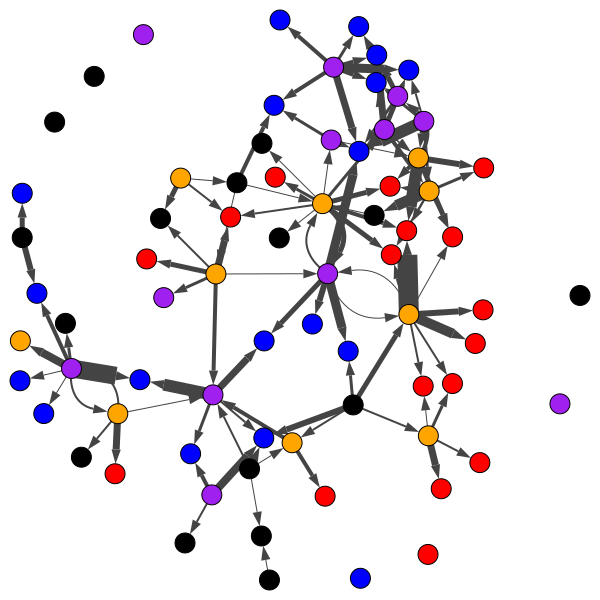

In [47]:
ig_plot(ell,edge_width = ell.es['weight'],vertex_color=ell.vs['color'])

In [32]:
vertex_color=['blue' if ell.vs['cell_type'] == 'mg1']

SyntaxError: invalid syntax (2532400938.py, line 1)

## GET most recent files (by filename date) in folder

In [ ]:
dirname = 'C:/Users/mpetkova/Dropbox/U19_zebrafish/EMfullres/LateralLineCurlDetector/CREST/right_afferents/'
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:/Users/EngertLab/Dropbox/CREST/mariela_fish_credentials.json'

names = os.listdir(dirname);
cellid_filename=list();
for ind in range(len(names)):
    content = names[ind].split('_')
    if ('cell' in content):
        cellid_filename.append(names[ind])
d={}
for name in cellid_filename:
    ID,content_type,date=name.split('_')[2], name.split('_')[0], name.split('_')[-1]
    date=date[:-5]
    #create entry in dict which holds ID, file type (ex: cell_graph) and file path
    if ID not in d:
        d[ID]=[date, name]
        #if there are multiple files with the same ID, keep the info for the newest one
    else:
        if date>d[ID][0]:
            d[ID][0]=date
            d[ID][1]=name
            
############################################################################################################################ 
# Collect all the base segments for each ID
import json

base_segs = {}

for key in d.keys():
    f = open(dirname+d[key][1])
    data = json.load(f)
    base_segs[key]=sum(data['base_segments'].values(),[])
    f.close()

############################################################################################################################ 


## Fix cell_data dictionary keys


In [90]:
filepath = Path("/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/")
filepath = filepath / "cell_graph_305332461__2023-04-01 21.04.03.json"

In [91]:
cell = ecrest(settings_dict,filepath = filepath,launch_viewer=False)

In [92]:
old_points = cell.cell_data['end_points']
old_points

{'exit volume': [],
 'natural': [],
 'bad alignment': [],
 'uncorrected split': [],
 'artefact': [],
 'natural end': [],
 'uncertain': [],
 'pre-synaptic': [],
 'post-synaptic': []}

In [93]:
end_points = {}
for p in cell.point_types:
    # if p not in cell.cell_data['end_points']:
    end_points[p] = []
        
cell.cell_data['end_points'] = end_points

In [66]:
cell.cell_data['end_points']['natural end'] = old_points['natural']

In [94]:
# cell.cell_data['end_points'].pop('natural')
cell.cell_data['end_points'].keys()

dict_keys(['exit volume', 'natural end', 'uncertain', 'pre-synaptic', 'post-synaptic'])

In [95]:
cell.save_cell_graph(directory_path = filepath.parent, file_name=filepath.name, save_to_cloud=False); #rewrites the original, not with a new time stamp

Saved cell 305332461 reconstruction locally at 2023-04-05 11.20.24


## Figure out what is wrong with a crest file

In [125]:
filepath = Path("/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/")
filepath = filepath / "cell_graph_213605530__2023-03-29 22.49.21.json"
cell = ecrest(settings_dict,filepath = filepath,launch_viewer=False)

In [127]:
cell.cell_data['end_points']['post-synaptic']

[]

## Fix pre-synaptic to be post-synaptic annotation list in converted crest jsons

In [157]:
json_fix = Path("/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/Complete/synapses/to-crest/conversion_specs_synapse_fix.json")

with open(json_fix,'r') as f:
    cells_to_fix = f.read()
    cells_to_fix = json.loads(cells_to_fix)

In [158]:
cells_to_fix = cells_to_fix['cell_info']

In [163]:
for k,v in cells_to_fix.items():
    try:
        filepath = nodefiles[k]
        cell = ecrest(settings_dict,filepath = filepath,launch_viewer=False)
        cell.cell_data['end_points']['post-synaptic'] = deepcopy(cell.cell_data['end_points']['pre-synaptic'])

        cell.cell_data['end_points']['pre-synaptic'] = []
        # cell.save_cell_graph(directory_path = filepath.parent / 'original', file_name=filepath.name, save_to_cloud=False); #rewrites the original, not with a new time stamp
    except KeyError as msg:
        print(msg)
        continue
        

Saved cell 214412684 reconstruction locally at 2023-04-05 12.11.10
Saved cell 214550811 reconstruction locally at 2023-04-05 12.11.10
Saved cell 215572949 reconstruction locally at 2023-04-05 12.11.10
Saved cell 216129202 reconstruction locally at 2023-04-05 12.11.10
Saved cell 220275752 reconstruction locally at 2023-04-05 12.11.10
Saved cell 297178666 reconstruction locally at 2023-04-05 12.11.10
Saved cell 299497999 reconstruction locally at 2023-04-05 12.11.10
Saved cell 299589324 reconstruction locally at 2023-04-05 12.11.10
Saved cell 300210608 reconstruction locally at 2023-04-05 12.11.10
Saved cell 300316308 reconstruction locally at 2023-04-05 12.11.10
Saved cell 300380579 reconstruction locally at 2023-04-05 12.11.10
"305035439'"
Saved cell 31102601 reconstruction locally at 2023-04-05 12.11.10
Saved cell 387368998 reconstruction locally at 2023-04-05 12.11.10
Saved cell 392213717 reconstruction locally at 2023-04-05 12.11.10
Saved cell 42802314 reconstruction locally at 2023

In [150]:
cell.cell_data['end_points']

{'exit volume': [],
 'natural end': [[142609.46875, 275542.6875, 45.0],
  [142776.15625, 278173.6875, 2775.0],
  [53208.87890625, 271123.09375, 13365.0],
  [70813.0859375, 267435.34375, 10044.652404785156],
  [51008.359375, 284277.96875, 56675.0830078125],
  [68367.4921875, 273829.5625, 31418.91357421875],
  [64639.48046875, 274508.65625, 35085.003662109375],
  [62399.1796875, 303022.0625, 106049.47265625],
  [54059.69921875, 292912.375, 77115.0],
  [115337.7109375, 289251.84375, 74204.99267578125],
  [140118.015625, 284278.375, 106005.0],
  [142204.484375, 284977.09375, 106005.0],
  [111865.0390625, 291143.6875, 67154.99267578125],
  [110964.0390625, 289608.1875, 66825.0],
  [109141.9609375, 289524.5625, 66975.0],
  [106861.765625, 289384.875, 68985.0],
  [222726.3125, 265308.8125, 60494.996337890625],
  [185022.09375, 273914.90625, 45135.0],
  [184830.203125, 272752.84375, 52605.0],
  [169899.09375, 265474.03125, 13754.999084472656],
  [135296.546875, 277537.78125, 40934.996337890625

## Anatomical Clustering